# The Weighted Ensemble Method

## Sodium Chloride Association Kinetics, with OpenMM

The Weighted Ensemble (WE) method provides a route to estimating kinetic and thermodynamic parameters for many different types of biomolecular simulation problem. For a good introduction, see this [2017 review from Zuckerman and Chong](https://pubmed.ncbi.nlm.nih.gov/28301772/).

The aim of this notebook is to illustrate the key aspects of "steady state" type WE simulations (walkers, progress coordinates, binning, splitting and merging, recycling) with a version of the sodium chloride association kinetics example that also features in the [WESTPA](https://pubmed.ncbi.nlm.nih.gov/26392815/) tutorials, but using `WElib` instead.

There is a barrier to the formation of a Na+ - Cl- ion pair in solution as the hydration shells that surround each ion - when separated -  must be disrupted. In this Weighted Ensemble simulation, we begin with a box of water containing one sodium and one chloride ion, about 11 Angstroms (1.1 nm) apart. We measure the rate at which this forms an ion pair (defined as <= 2.6 Angstroms apart).

### Part 0: Install WElib (if not done already)

In [1]:
!pip install git+http://github.com/CharlieLaughton/WElib.git

  Cloning http://github.com/CharlieLaughton/WElib.git to /private/var/folders/x4/yxxm9x3s7ns4stck5237hhfm0000gn/T/pip-req-build-5gefcjmf
  Running command git clone --filter=blob:none --quiet http://github.com/CharlieLaughton/WElib.git /private/var/folders/x4/yxxm9x3s7ns4stck5237hhfm0000gn/T/pip-req-build-5gefcjmf
  Resolved http://github.com/CharlieLaughton/WElib.git to commit 5352bcdb8d9e12c0c263772bdbfd8ce68ac94563
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for WElib: filename=WElib-0.0.1-py3-none-any.whl size=11505 sha256=01b2aabf8766b0913909104a6125aebe695b1056b41641aa1b98a6d64f4be8da
  Stored in directory: /private/var/folders/x4/yxxm9x3s7ns4stck5237hhfm0000gn/T/pip-ephem-wheel-cache-a06d264k/wheels/d5/57/31/5b582a43d955fb92aa8eb97b21e916c27bfe7c31f7261ec018
Successfully built WElib


### Part 1: Building the OpenMM system
We begin by importing the packages required to build the simulation system in OpenMM: 

In [1]:
import openmm.app as omm_app
import openmm as omm
import openmm.unit as unit

Now we create the `system`, and then a `simulation` object:

In [2]:
prmtop = omm_app.AmberPrmtopFile('nacl.parm7')
inpcrd = omm_app.AmberInpcrdFile('nacl_unbound.ncrst')
system = prmtop.createSystem(nonbondedMethod=omm_app.PME, nonbondedCutoff=10.0*unit.angstrom,
        constraints=omm_app.HBonds)

T = 300.0 * unit.kelvin  ## temperature
fricCoef = 1.0 / unit.picoseconds ## friction coefficient 
stepsize = 0.002 * unit.picoseconds ## integration step size
integrator = omm.LangevinIntegrator(T, fricCoef, stepsize)

simulation = omm_app.Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors is not None:
    simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)
    
print(f'OpenMM will use the {simulation.context.getPlatform().getName()} platform')

OpenMM will use the OpenCL platform


The simulation system uses periodic boundary conditions, so later we will need a utility to correct for imaging issues. Here's a class to do it:

In [3]:
class PBCImager():
    '''
    Tools to manipulate coordinate data with regards to PBC
    
    '''
    def __init__(self, unitcell_vectors):
        self.A = unitcell_vectors.T
        self.B = np.linalg.inv(self.A)

    def pack(self, xyz, centre_atom_indices=None):
        """
        Pack a set of coordinates into the periodic cell
        
        Optionally place the c.o.g. of a selection of atoms at the box centre
        """
        if centre_atom_indices is not None:
            box_centre = np.matmul(self.A, [0.5, 0.5, 0.5])
            dv = box_centre - xyz[centre_atom_indices].mean(axis=0)
        else:
            dv = 0.0
        r = xyz + dv
        f = np.matmul(self.B, r.T)
        g = f - np.floor(f)
        t = np.matmul(self.A, g)
        xyz_packed = t.T - dv
        return xyz_packed

    def image(self, vector):
        """
        Return a vector imaged to be as short as possible
        """
        lmin = (vector * vector).sum()
        vopt = vector
        f = np.matmul(self.B, vector.T)
        g = f - np.floor(f)
        for a in [0, 1]:
            for b in [0, 1]:
                for c in [0, 1]:
                    gtmp = g - np.array([a, b, c])
                    t = np.matmul(self.A, gtmp)
                    l = (t * t).sum()
                    if l < lmin:
                        lmin = l
                        vopt = t
        return vopt


### Part 2: Building the WE workflow
Now we import WElib and other utilities that will be useful. Many are the same as those used for the simple double well potential example, but we have OpenMM-compatible versions of the `Stepper` and `ProgressCoordinator`:

In [4]:
import mdtraj as mdt
import numpy as np
import time
from WElib import Walker, FunctionStepper, FunctionProgressCoordinator, Recycler, StaticBinner, SplitMerger

Create some walkers, each begins in the initial, dissociated, state:

In [5]:
initial_state = simulation.context.getState(getPositions=True, enforcePeriodicBox=True)

n_reps = 5
walkers = [Walker(initial_state, 1.0/n_reps) for i in range(n_reps)]
for w in walkers:
    print(w)

unitcell_vectors = initial_state.getPeriodicBoxVectors(asNumpy=True)/ unit.nanometers

<WElib.Walker weight = 0.2, pcs = [], bin = None>
<WElib.Walker weight = 0.2, pcs = [], bin = None>
<WElib.Walker weight = 0.2, pcs = [], bin = None>
<WElib.Walker weight = 0.2, pcs = [], bin = None>
<WElib.Walker weight = 0.2, pcs = [], bin = None>


The progress coordinate will be the distance between the sodium and chloride ion. Create a function that can calculate this from the OpenMM state (correcting for PBC issues), then build the ProgressCoordinator with it:

In [6]:
def pc_func(state, imager=None):
    '''
    Given an OPenMM state, return the distance between the Na and Cl atoms
    
    May correct for PBC
    
    '''
    na_atom = 0 # index of the sodium atom in the system
    cl_atom = 1 # index of the chloride ion in the system
    crds = state.getPositions(asNumpy=True) / unit.nanometer
    dx = crds[na_atom] - crds[cl_atom]
    if imager:
        dx = imager.image(dx)
    r = dx * dx
    pc = np.linalg.norm(r)
    return pc

progress_coordinator = FunctionProgressCoordinator(pc_func, PBCImager(unitcell_vectors))
walkers = progress_coordinator.run(walkers)
for w in walkers:
    print(w)

<WElib.Walker weight = 0.2, pcs = [0.7694168430471353], bin = None>
<WElib.Walker weight = 0.2, pcs = [0.7694168430471353], bin = None>
<WElib.Walker weight = 0.2, pcs = [0.7694168430471353], bin = None>
<WElib.Walker weight = 0.2, pcs = [0.7694168430471353], bin = None>
<WElib.Walker weight = 0.2, pcs = [0.7694168430471353], bin = None>


We will recycle walkers when the Na-Cl distance falls below 0.26 nm. As the progress coordinate is something that gets smaller as we move towards the target state, this is a "retrograde" coordinate:

In [7]:
recycler = Recycler(0.26, retrograde=True)
walkers = recycler.run(walkers)

print('recycled flux = ',recycler.flux)

recycled flux =  0.0


We use the same bin boundaries as in the WESTPA tutorials. Notice these are closer-spaced at shorter distances, as the solvation shells get "stiffer":

In [8]:
binner = StaticBinner([0, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.45, 0.5, 
                 0.55, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5])
walkers = binner.run(walkers)
for w in walkers:
    print(w)

<WElib.Walker weight = 0.2, pcs = [0.7694168430471353], bin = 14>
<WElib.Walker weight = 0.2, pcs = [0.7694168430471353], bin = 14>
<WElib.Walker weight = 0.2, pcs = [0.7694168430471353], bin = 14>
<WElib.Walker weight = 0.2, pcs = [0.7694168430471353], bin = 14>
<WElib.Walker weight = 0.2, pcs = [0.7694168430471353], bin = 14>


The SplitMerger is just the same as that used for the DWP example. We create it and run it, even though we know that at this time it will have nothing to do:

In [9]:
splitmerger = SplitMerger(n_reps)
walkers = splitmerger.run(walkers)
for w in walkers:
    print(w)

<WElib.Walker weight = 0.2, pcs = [0.7694168430471353], bin = 14>
<WElib.Walker weight = 0.2, pcs = [0.7694168430471353], bin = 14>
<WElib.Walker weight = 0.2, pcs = [0.7694168430471353], bin = 14>
<WElib.Walker weight = 0.2, pcs = [0.7694168430471353], bin = 14>
<WElib.Walker weight = 0.2, pcs = [0.7694168430471353], bin = 14>


Create a function that will run an OpenMM simulation. The function needs to take the current state of the system as its first argument, and return the final state at the end of the MD. Then use this created function to initialise a FunctionStepper, as was done for the DWP example.

In [10]:
def OMMSim(state, simulation, nsteps):
    simulation.context.setPositions(state.getPositions())
    simulation.context.setPeriodicBoxVectors(*state.getPeriodicBoxVectors())
    simulation.step(nsteps)
    return simulation.context.getState(getPositions=True, enforcePeriodicBox=True)

stepper = FunctionStepper(OMMSim, simulation, 500)

Now we will apply the stepper. Note this will take some time longer to run than in the DWP example, exactly how long will depend on power of your laptop/workstation:

In [11]:
start_time = time.time()
new_walkers = stepper.run(walkers) # this is where the MD happens
end_time = time.time()
print(f'{len(walkers)} simulations completed in {end_time-start_time:6.1f} seconds')

5 simulations completed in    3.9 seconds


Let's see where those MD steps have moved each walker to:

In [12]:
new_walkers = progress_coordinator.run(new_walkers)
new_walkers = recycler.run(new_walkers)
print('recycled flux = ', recycler.flux)
for w in new_walkers:
    print(w)

recycled flux =  0.0
<WElib.Walker weight = 0.2, pcs = [0.7276281888411282], bin = None>
<WElib.Walker weight = 0.2, pcs = [0.932127378162377], bin = None>
<WElib.Walker weight = 0.2, pcs = [0.8011615623350581], bin = None>
<WElib.Walker weight = 0.2, pcs = [0.9041868764479465], bin = None>
<WElib.Walker weight = 0.2, pcs = [0.8319387740564717], bin = None>


Apply the Binner and SplitMerger to the list of walkers:

In [13]:
new_walkers = binner.run(new_walkers)
new_walkers = splitmerger.run(new_walkers)
for w in new_walkers:
    print(w)

<WElib.Walker weight = 0.04000000000000001, pcs = [0.7276281888411282], bin = 14>
<WElib.Walker weight = 0.04000000000000001, pcs = [0.7276281888411282], bin = 14>
<WElib.Walker weight = 0.04000000000000001, pcs = [0.7276281888411282], bin = 14>
<WElib.Walker weight = 0.04000000000000001, pcs = [0.7276281888411282], bin = 14>
<WElib.Walker weight = 0.04000000000000001, pcs = [0.7276281888411282], bin = 14>
<WElib.Walker weight = 0.08000000000000002, pcs = [0.9041868764479465], bin = 16>
<WElib.Walker weight = 0.08000000000000002, pcs = [0.9041868764479465], bin = 16>
<WElib.Walker weight = 0.08000000000000002, pcs = [0.9041868764479465], bin = 16>
<WElib.Walker weight = 0.08000000000000002, pcs = [0.932127378162377], bin = 16>
<WElib.Walker weight = 0.08000000000000002, pcs = [0.932127378162377], bin = 16>
<WElib.Walker weight = 0.08000000000000002, pcs = [0.8011615623350581], bin = 15>
<WElib.Walker weight = 0.08000000000000002, pcs = [0.8319387740564717], bin = 15>
<WElib.Walker weig

### Part 3: Iterating the WE workflow
OK, that's all the components in place, they have been tested individually and seem to be bahaving. Time to run a few cycles:

In [14]:
n_cycles=10
print(' cycle    n_walkers   left-most bin  right-most bin   flux')
for i in range(n_cycles):
    new_walkers = stepper.run(new_walkers)
    new_walkers = progress_coordinator.run(new_walkers)
    new_walkers = binner.run(new_walkers)
    new_walkers = recycler.run(new_walkers)
    if recycler.flux > 0.0:
        new_walkers = progress_coordinator.run(new_walkers)
        new_walkers = binner.run(new_walkers)
    new_walkers = splitmerger.run(new_walkers)
    occupied_bins = list(binner.bin_weights.keys())
    print(f' {i:3d} {len(new_walkers):10d} {min(occupied_bins):12d} {max(occupied_bins):14d} {recycler.flux:20.8f}')

 cycle    n_walkers   left-most bin  right-most bin   flux
   0         30           11             17           0.00000000
   1         40           11             20           0.00000000
   2         50           11             21           0.00000000
   3         60           11             22           0.00000000
   4         60           11             22           0.00000000
   5         70            9             22           0.00000000
   6         75            5             22           0.00000000
   7         85            4             22           0.00000000
   8         95            4             22           0.00000000
   9        100            1             22           0.00009199


The take-home message should be fairly obvious: even on a system as small as this, you can't really run WE simulations interactively - they need time and considerable compute resources. We'll come to how you can move from Jupyter Notebooks to HPC systems in a later part of the workshop. But for now, let's see how we can get some useful/interesting data from the stepper's `Recorder`.

#### Generating trajectory files
You can use MDTraj to write out the path taken so far by any of the walkers in the form of a trajectory that could be visualised. 

The `replay` method of the recorder outputs a list of the states visited by the given walker. Being OpenMM states, these have a `getPositions` method that can be used to extract atom coordinates, which can then be used to generate an MDTraj `trajectory`:

In [22]:
chosen_walker = 0
top = mdt.load_topology('nacl.parm7')
xyz = []
for s in stepper.recorder.replay(new_walkers[chosen_walker]):
    xyz.append(s.getPositions(asNumpy=True) / unit.nanometer)
t = mdt.Trajectory(xyz, top)
print(t)
t.save(f'walker_trajectory_{chosen_walker}.nc')

<mdtraj.Trajectory with 12 frames, 4010 atoms, 1338 residues, without unitcells>


#### Plotting progress coordinates
You can plot the history of the progress coordinate of a walker. Create a list of fresh walkers, each initialised with one of the states visited by the chosen walker. Then pass this list through the `ProgressCoordinator` to add PC data, then you can plot this:

Text(0, 0.5, 'progress coordinate')

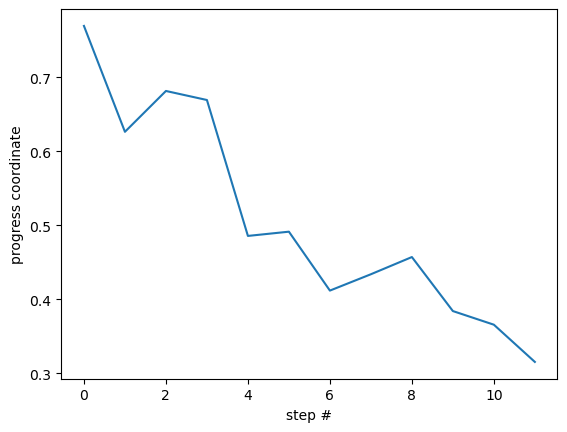

In [25]:
from matplotlib import pyplot as plt
%matplotlib inline
chosen_walker = -1
walker_list = [Walker(state, 1.0) for state in stepper.recorder.replay(new_walkers[chosen_walker])]
walker_list = progress_coordinator.run(walker_list)
plt.plot([w.pcs[0] for w in walker_list])
plt.xlabel('step #')
plt.ylabel('progress coordinate')

### Analysis of a longer simulation

We have provided you with the log file, `nacl.log` obtained when this simulation was run for 500 cycles (each cycle being 2ps, rather than 1ps as above).

In [26]:
# Extract data from the log file. Get:
#
# n_walkers: the number of walkers each cycle
# flux: the recycled flux, each cycle
# bin_weights: a dictionary with the cumulative weight of simulation in each bin
#
with open('nacl.log') as f:
    data = f.readlines()

n_walkers = []
flux = []
for d in data[1:-1]:
    w = d.split()
    n_walkers.append(int(w[1]))
    flux.append(float(w[4]))

n_walkers = np.array(n_walkers)
flux = np.array(flux)
bin_weights = eval(data[-1])

# normalise bin weights:
mean_weights = np.array(list(bin_weights.values()))
mean_weights /= mean_weights.sum() 

Plot key data:

mean flux = 9.468e-05


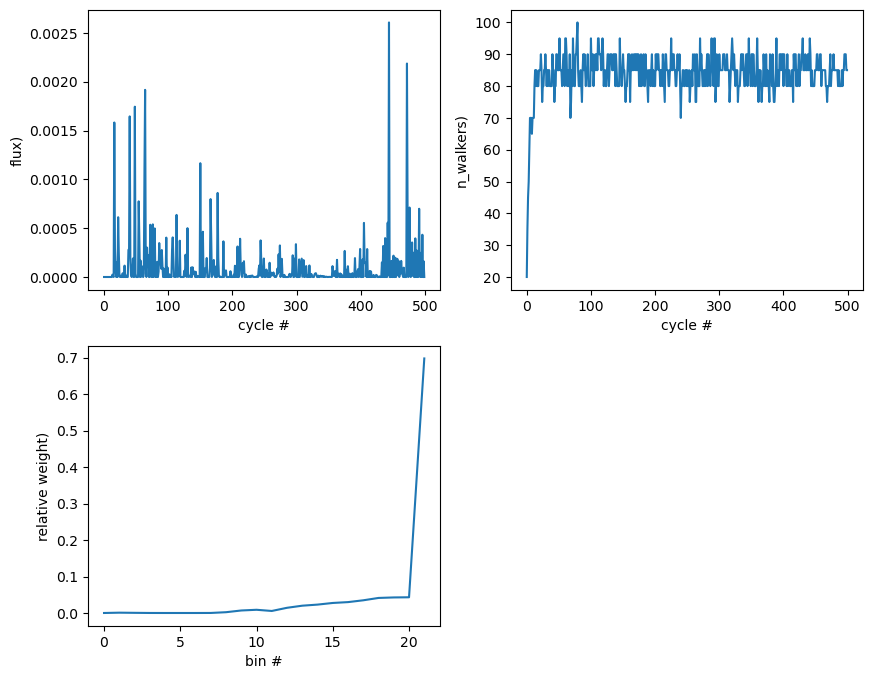

In [27]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,8))
plt.subplot(221)
plt.plot(flux)
plt.xlabel('cycle #')
plt.ylabel('flux)')
plt.subplot(222)
plt.plot(n_walkers)
plt.xlabel('cycle #')
plt.ylabel('n_walkers)')
plt.subplot(223)
plt.plot(mean_weights)
plt.xlabel('bin #')
plt.ylabel('relative weight)')
print(f'mean flux = {flux[30:].mean():6.4g}')

The erratic pattern of flux recycling, and the rapid increase and then plateauing in the number of walkers each cycle, are apparent. The majority of the simulation weight remains in the last bin (Na-Cl sepaation > 1.5 nm). To calculate the association rate from the flux, we need to decide on where the boundary between the unassociated and associated states is, and - as this is an association rate constant with units of 1/(time\*concentration) - do a volume correction.

Zooming in a bit on the weights data reveals a 'kink' in the profile that is a fair guide to where the transition state probably is (there is no neeed to be super-exact about this in a case like this). It suggests we can regard the first 10 bins as being on the associated side of the barrier, so the rest count towards the unassociated concentration:

Text(0, 0.5, 'relative weight)')

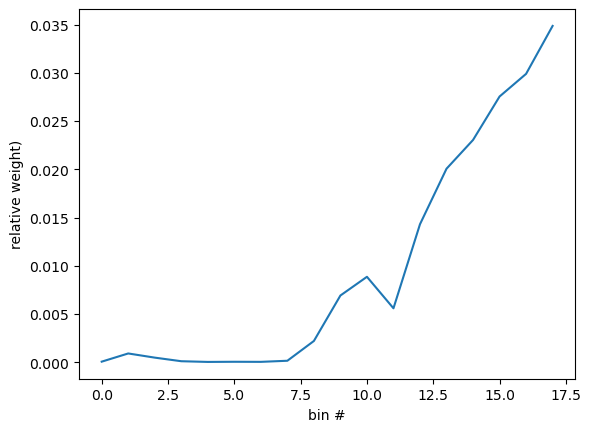

In [28]:
plt.plot(mean_weights[:18])
plt.xlabel('bin #')
plt.ylabel('relative weight)')

Now the volume correction. The maths below calculates this for a triclinic periodic cell:

In [29]:
bv = inpcrd.boxVectors
a, b, c = [np.linalg.norm(b) for b in bv] # unit cell vector lengths
unit_vectors = [b / np.linalg.norm(b) for b in bv]
cosalpha = np.dot(unit_vectors[1], unit_vectors[2]) #
cosbeta = np.dot(unit_vectors[0], unit_vectors[2])  # unit cell angles
cosgamma = np.dot(unit_vectors[0], unit_vectors[1]) #
volume = a*b*c*(1 - cosalpha**2 - cosbeta**2 - cosgamma**2) + 2* np.sqrt(np.abs(cosalpha*cosbeta*cosgamma))
print(f'unit cell volume = {volume:6.4g} nm**3')

unit cell volume =  35.64 nm**3


In [30]:
boundary_bin = 10 # boundary between what's considered "associated" and "disassociated"
w_u = mean_weights[boundary_bin:].sum() / mean_weights.sum()
print(f'unbound weight = {w_u:6.4g}')

NA = 6.022e+23
nm3_to_dm3 = 1e-24
time_step_to_seconds = 1 / 5e11 # the WE simulations are 2 ps per cycle
concentration = w_u / (volume * NA * nm3_to_dm3)
print(f'concentration of unassociated ion = {concentration:6.4g} M')

k_assoc = flux.mean() / (concentration * time_step_to_seconds)
print(f'Association rate constant = {k_assoc:6.4g} / M.second')

unbound weight =  0.989
concentration of unassociated ion = 0.04608 M
Association rate constant = 1.031e+09 / M.second


The result is quite close to the diffusion limit for bimolecular asssociation in water (about 7e9 /M.second, see [here](https://en.wikipedia.org/wiki/Diffusion-controlled_reaction).

### Experiments to try:

What happens to the predicted association constant if you decide to move the division between bound and unbound states to a different bin boundary?

You will find a restart file for the "bound" state of the NaCl system in this directory. Try to construct a WE workflow to predict the unbinding rate.